# Simple CSTR State-estimation: MHE
(By David T)

### 0. Introduction
In this example, the state-estimation of a simple CSTR reactor is demonstrated with the *CAPRESE* tools. For this model, a non-isothermal CSTR model is used. The kinetics represent the reaction between thiosulfate and hydrogen peroxide,
\begin{align}
\dfrac{dC_{A}}{dt} &= \dfrac{F}{V} \left(C_{A}^{in} - C_{A} \right) - 2k T_{R}C_{A}^{2} \\
\dfrac{dT_{R}}{dt} &= \dfrac{F}{V} \left(T_{R}^{in} - T_{R} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
\dfrac{dT_{cw}}{dt} &= \dfrac{F_{cw}}{V_{cw}} \left(T_{cw}^{in} - T_{cw} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
k \left(T_{R} \right) &= k_{0} \exp \left(\dfrac{-E_{a}}{RT_{R}} \right)
\end{align}
Where $C_{A}$ is the concentration of thiosulfate, $T_{R}$ is the reactor temperature and the cooling water temperature $T_{cw}$.  
For this problem, a simple MHE strategy will be used, that is a formulation as follows:
begin{equation} 
 \begin{split}
 \min_{x_{-\mathcal{N}},\mathbf{w}_{k}, \mathbf{v}_{k}} \quad & \Phi_{-\mathcal{N}} \left(x_{-\mathcal{N}|k}, x_{-\mathcal{N}|k-1}, \Pi _{-\mathcal{N}|k-1}\right)+  \\ &        \quad  +  \sum_{i=-\mathcal{N}}^{0} v_{i|k}^{T} \mathcal{R}^{-1}_{i} v_{i|k} + \sum_{i=-\mathcal{N}}^{-1}w^{T}_{i|k} \mathcal{Q}^{-1}_{i} w_{i|k}\\
 \text{s.t.} \quad  &x_{l+1|k} = f \left(x_{l|k}\right) + w_{l|k}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace\\
 &y\left(k+l\right) = h \left(x_{l|k}\right) + v_{l|k}, \quad   l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &x_{l|k} \in \mathbb{X}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &w_{l|k} \in \mathbb{W}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace,\\
 \end{split}
 \end{equation}

where, $x$ correspond to states, $y$ the measurements, $v$ the measurement noise, and $w$ the plant disturbance.

### 1. MHE object set up

In [1]:
from nmpc_mhe.aux.utils import load_iguess
from nmpc_mhe.aux.utils import reconcile_nvars_mequations  #: counts n_var and m_equations from nl
from nmpc_mhe.pyomo_dae.MHEGen_pyDAE import MheGen_DAE
from sample_mods.cstr_rodrigo.cstr_c_nmpc import cstr_rodrigo_dae
from pyomo.environ import *
import matplotlib.pyplot as plt
import os, sys

With similar ideas in mind as the NMPC object set-up, a predefined model needs to have the appropriate ports for controls. Therefore, for the specific MHE problem, it is necessary to define the measurement variables.

In [2]:
measurements = ['T']

The remaining information corresponds to the state and control information. For this example it is declared to keep consistency.

In [3]:
states = ["Ca", "T", "Tj"]
controls = ["u1"]
u_bounds = {"u1": (200, 1000)}
state_bounds = {"Ca": (0.0, None), "T":(2.0E+02, None), "Tj":(2.0E+02, None)}
ref_state = {("Ca", (0,)): 0.010}

In [4]:
mod = cstr_rodrigo_dae(2,2)

In this way the MHE object can be created. 

In [5]:
e = MheGen_DAE(mod, 2, states, controls, states, measurements,
               u_bounds=u_bounds,
               ref_state=ref_state,
               override_solver_check=True,
               var_bounds=state_bounds,
               k_aug_executable='/home/dav0/in_dev_/WorkshopFraunHofer/caprese/k_aug/bin/k_aug')

New model at 140588612571936
New timebounds defined!
New model at 140588612574816
New timebounds defined!
Model: unknown Bounds activated
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 140588612293808
New model at 140588612403024
New timebounds defined!
New timebounds defined!
Model: LSMHE (Least-Squares MHE) Bounds activated


W0[[Initializing MHE]]The Q_MHE and R_MHE matrices are diagonal.


### 2. Preparation phase
The MHE problem requires more information to be constructed than  the NMPC; for instance weight matrices

In [6]:
Q = {}
U = {}
R = {}
Q['Ca'] = 1.11
Q['T'] = 99.0
Q['Tj'] = 1.1
U['u1'] = 0.22
R['T'] = 1.22
e.set_covariance_disturb(Q)
e.set_covariance_u(U)
e.set_covariance_meas(R)
e.lsmhe.U_mhe.pprint()
e.create_rh_sfx()

U_mhe : Size=5, Index=U_mhe_index, Domain=Any, Default=None, Mutable=True
    Key       : Value
    (0, 'u1') : 4.545454545454546
    (1, 'u1') : 4.545454545454546
    (2, 'u1') : 4.545454545454546
    (3, 'u1') : 4.545454545454546
    (4, 'u1') : 4.545454545454546


Then, it is necessary to load initial guesses.

In [7]:
e.get_state_vars()
e.load_iguess_steady()
load_iguess(e.SteadyRef, e.PlantSample, 0, 0)
e.solve_dyn(e.PlantSample)

{'Ca': [(0,)], 'T': [(0,)], 'Tj': [(0,)]}
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_steady_ref]]labels at 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef.--------------------
/tmp/tmpk6ld5grv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                              bound_push = 1e-07                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274170.754426vanilla0  yes
            

optimal


Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274170.806913vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

T

optimal


0

And finally start the preparation phase of the *mhe*

In [8]:
e.init_lsmhe_prep(e.PlantSample)
e.shift_mhe()
e.init_step_mhe()
e.solve_dyn(e.lsmhe,
            skip_update=False,
            max_cpu_time=600,
            ma57_pre_alloc=5, tag="lsmhe")  #: Pre-loaded mhe solve

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[init_lsmhe_prep]]Preparation phase MHE.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmph9f_gc9z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 y

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274170.945131vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpon1dtmg5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274171.007676vanilla

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpc8h37dkv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274171.068461vanilla

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274171.124445vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Preparation MHE.--------------------
/tmp/tmp2rl242jm.pyomo.nl -AMPL halt_on_ampl_error=yes 
Ipopt vanilla0: halt_on_ampl_error=yes
halt_on_ampl_error=yes


List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 1e-06                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_lsmhe]]Attempting to initialize lsmhe Done.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpfnokbleo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300

optimal


/tmp/tmp_73tdnbs.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 3000                  yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      513
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


0

In [9]:
e.check_active_bound_noisy()
e.load_covariance_prior()
e.set_state_covariance()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4993; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 129
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 17
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601034229527142 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033361066351 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 129, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 513
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 67
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000000
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 94
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [10]:
e.regen_objective_fun()  #: Regen erate the obj fun
e.deact_icc_mhe()  #: bRemove the initial conditions

In [11]:
ca = e.PlantSample.Ca[2, 0]
t = e.PlantSample.T[2, 0]
u = e.PlantSample.u1[2]
tj = e.PlantSample.Tj[2, 0]

ca_mhe = e.lsmhe.Ca[10, 0]
t_mhe = e.lsmhe.T[10, 0]
tj_mhe = e.lsmhe.Tj[10, 0]

spl = []
ul = []
cal = []
tl = []
tjl = []

ca_mhel = []
t_mhel = []
tj_mhel = []

### 4. Main state estimation loop

The main estimator loop for this example calculates the states under random noise. Then it basically:  
1. Generates noise
2. Simulates plant
2. Reads measurement
3. Initializes MHE
4. Attempts to solve MHE
5. Post optimality: prior-covariance
6. Cycle plant

In [12]:
for i in range(0, 60):  #: Five steps
    if i < 20:
        sigma = 0.0005
    elif 20 < i < 40:
        sigma = 0.0015
    else:
        sigma = 0.002
    e.noisy_plant_manager(sigma=sigma, action="apply", update_level=True)
    e.solve_dyn(e.PlantSample, stop_if_nopt=True)
    cal.append(value(ca))
    tl.append(value(t))
    tjl.append(value(u))
    e.update_state_real()  # update the current state
    e.update_measurement()
    e.compute_y_offset()  #: Get the offset for y
    e.preparation_phase_mhe(as_strategy=False)

    stat = e.solve_dyn(e.lsmhe,
                       skip_update=False, iter_max=500,
                       jacobian_regularization_value=1e-04,
                       max_cpu_time=600, tag="lsmhe", keepsolve=False, wantparams=False)

    if stat == 1:  #: Try again
        e.lsmhe.write_nl(name="bad_mhe.nl")
        stat = e.solve_dyn(e.lsmhe,
                           skip_update=True,
                           max_cpu_time=600,
                           stop_if_nopt=True,
                           jacobian_regularization_value=1e-02,
                           linear_scaling_on_demand=True, tag="lsmhe")
        if stat != 0:
            sys.exit()
    e.update_state_mhe()  #: get the state from mhe
    ca_mhel.append(value(ca_mhe))
    t_mhel.append(value(t_mhe))
    tj_mhel.append(value(tj_mhe))
    #: At this point computing and loading the Covariance is not going to affect the sens update of MHE
    e.prior_phase()
    e.print_r_mhe()
    e.print_r_dyn()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp2w1tj1al.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274171.619992vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpidcjyzdu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


/tmp/tmpve0vicsb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.825882; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-4.695417101885647 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-4.695417101885635 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 43810.239214
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmptq24d40a.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpofi1hllj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpc77u1d50.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0632804; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103348761721 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601034346045706 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000096
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp7__21fwg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274172.340536vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpv7y6j5bz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpk4fq22u3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.491096; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726468954 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303016942 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000137
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274172.678847vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpnnptay3n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0i_t8j3w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.509241; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727084248 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302736091 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000183
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274173.005571vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

T

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzdx04205.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpdjtaqqrt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.48889; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372744541 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303105657 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000044
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp3mj58sbf.pyomo.nl -AMPL 


optimal


/tmp/tmptvaqzpzv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpg1pxejd7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.485507; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727623912 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303360463 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000225
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpykq7i9ad.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274173.623627vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmp7gj4ycfe.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5hwogcw3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.48009; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727588698 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303283439 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000121
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274173.899655vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpm_h8fhy3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp7fz6jxqv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4524; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728012125 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303827023 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000025
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274174.258220vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmps7_redie.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4896; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727511497 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303077132 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000372
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpdub7m7bq.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpn202_f9r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmps1boqg3v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.443276; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727829783 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303517031 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000684
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274174.872122vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpkkvqpml1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpsunpo62a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.457316; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727949385 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303685151 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000538
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274175.165210vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp2frhvw4o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.51136; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.6010337273706 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330289105 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000912
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 s

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmppw4vh4mt.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptvcb49uu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp80s1olxs.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.419963; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727765216 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303468675 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000607
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274175.748483vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


/tmp/tmpr5wo4x85.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpld7f8jqf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.41614; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728441829 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304275317 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001130
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp040skbg0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274176.040814vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpmps2100n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxyhrbma0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.415852; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728175969 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303756925 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000486
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274176.319888vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
       

optimal


/tmp/tmpe2s1zuqy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpstkzadvk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.402759; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372871611 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330461197 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000780
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274176.595497vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


/tmp/tmpasb8mv8p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.419204; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728134155 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303764298 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000337
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpn8memvgq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274176.891594vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp3fbvh_zt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpl0ryrazx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.371343; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728943635 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330488647 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000561
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274177.171163vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpw_p__gyr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.416149; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728210547 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303791032 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000452
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274177.449058vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3o_336td.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.392798; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728652299 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304521193 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001146
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274177.718946vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


/tmp/tmpk4peu63k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.425125; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727985863 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330359267 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002759
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp8a03kwie.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274178.011001vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpd0wer38g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3hhea1y2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.379658; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728294995 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304008949 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007504
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274178.288222vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


/tmp/tmpjn5dz2d_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp4ybe89za.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.434825; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727933217 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303472914 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.009443
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpq47ygu6y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274178.579490vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpqpxfguha.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp9mtv5y30.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.331042; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728391128 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330408685 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.019429
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpn6290vap.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274178.875864vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpgcevp7gc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpmewhfe9i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.364008; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728755125 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304139737 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011259
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpx074olbl.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp0_p6qcrn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpom16nsec.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.197714; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731069567 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307112829 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.008929
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpxrlzcawg.pyomo.nl -AMPL 


optimal


/tmp/tmphnv81zsa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpx0wkdpzi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.316921; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033730731503 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033306225592 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006193
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274179.737101vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


/tmp/tmp2_jn2dg_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5u5td7w5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.107054; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033733619822 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103331018547 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006308
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274180.006902vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpqo7xzno2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.210867; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033732559355 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033308436936 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.008360
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpcgimpuub.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274180.298719vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp16yef3gm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.195841; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731976226 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330789111 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011915
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp7y04ds_1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274180.576744vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpuaankc9a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.247084; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731014446 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033306761442 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.010388
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274180.848240vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpasrpimdu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.241692; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103373079205 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033306621673 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003721
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274181.125096vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal



I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpqg7n99_u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjmorauf7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.263254; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731150267 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307001925 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.012506
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpcaxu_k_r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274181.439026vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpx4n_t4dx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_k92rctc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.269921; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731690357 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307487393 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.017488
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpdmib4jox.pyomo.nl -AMPL 


optimal


/tmp/tmps6swvax8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxhwabuyr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.329454; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033732811313 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033309164263 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011345
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpa5dgo3s_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274182.023691vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpue7r7m8s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5mxg4r4l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.34733; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033729851842 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033305181575 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011181
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpkc0iwxd1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274182.309214vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpq9vk2ced.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp1xlnz0l0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.283298; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731355997 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307182783 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.016017
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp4hg1rkw8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274182.587117vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpqe1af4r2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpi530d7nm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.174696; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033733418047 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033309597492 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.017650
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpm8y7py4c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274182.880665vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


/tmp/tmp9ohu3wig.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.228252; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033732555118 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330834606 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.026055
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpr8od40rb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274183.165566vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpdrl6vtds.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpokhf_2cd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.289814; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033731763483 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307293335 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.028815
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                                max_iter = 3000                  yes
                             output_file = 1568274183.453700vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequalit

optimal


/tmp/tmpfm48muzz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpj32ewme1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.23783; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103373279583 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033308793776 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.042805
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpxqdr40a7.pyomo.nl -AMPL 


optimal


/tmp/tmpuojyg5wb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0vu900zh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.290938; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033732724078 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033308243712 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.059776
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274184.029701vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpozoquen5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.239898; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033734261406 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033310201062 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.064107
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274184.309049vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
       

optimal


/tmp/tmpldo1womw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0evgza8m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.264542; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033734511143 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033310223393 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.067685
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp25uwf3mf.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptxm0z506.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpm12tm1rg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.257313; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033735724679 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033311588502 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.059219
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpa_n02jo7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274184.946376vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmp773lig1a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjvszaoe0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.170386; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033738025182 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033314328863 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.035317
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmprpo5vdfw.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpgps69zf1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpsqn_6rc4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.162486; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033738723505 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033315117066 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.033108
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274185.569358vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpiosp8p7q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpj5c_a5dm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.157529; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033739203192 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033315457089 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.023714
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274185.862203vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


/tmp/tmpgmqwcnod.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp6zh4_i4k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0314934; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033739673262 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033316372392 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.024156
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp1lc_53ad.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274186.165830vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpusijaruo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.225725; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103373653512 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033312313588 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.046939
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274186.441551vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


/tmp/tmp4wg4v5x0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpyzczjqvk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.200598; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033735944384 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033311998743 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.048786
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp_09760o6.pyomo.nl -AMPL 


optimal


/tmp/tmp2g8e7pna.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpm31b5zpb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.195001; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033734975388 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033310933191 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.042627
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274187.062602vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


/tmp/tmpf9nvkmlg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpefrxsys2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.301335; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033733438197 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033308893951 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.067936
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp50a79hi7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274187.369349vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp4gyiu9vk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.208139; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033736096497 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033312220741 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.041193
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568274170.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpm_oe1sql.pyomo.nl -AMPL 


optimal


/tmp/tmpq5cn9a4h.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp4amfvbuc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0857786; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103373814752 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103331469875 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.048483
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpfmwaymk3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274187.959974vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpdbj4axk4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.272867; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033735663819 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033310976616 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.037131
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274188.236646vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp8zrxo4_u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplgc4bzi5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0279755; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033739717822 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033316850502 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.054264
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274188.510796vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpoj8hc71j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.259785; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033736726759 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033312130129 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.063458
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274188.836236vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpq6b273xx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpydtat_cl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.125754; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033737823423 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033314248484 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.081120
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpkp792xao.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568274189.153245vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpyhyxp48b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpns4x45du.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.26973; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033735809548 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033311202762 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.101433
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [13]:
err_ca = [abs(ca_mhel[i] - cal[i])/cal[i] for i in range(0, len(cal))]
err_t = [abs(t_mhel[i] - tl[i])/tl[i] for i in range(0, len(tl))]
err_tj = [abs(tj_mhel[i] - tjl[i])/tjl[i] for i in range(0, len(tjl))]

### 5. Results

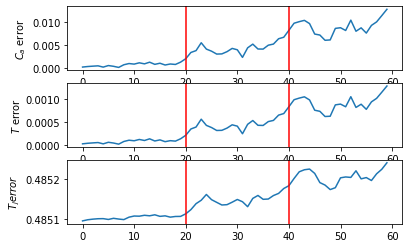

In [16]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(err_ca)
plt.ylabel("$C_{a}$ error")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")


plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(err_t)
plt.ylabel("$T$ error")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(err_tj)
plt.ylabel("$T_{j} error$")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")
plt.show()

### Credits:
 - David Thierry (Carnegie Mellon University @2019)